In [1]:
#Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import warnings
from sklearn.model_selection import train_test_split
import pickle
from MVDD.MVDD import MVDD
import MVDD.MVDD_Generator as mvGen

plt.rc('font', size=12)
warnings.filterwarnings('ignore')

# Hemo

In [2]:
#Load original dataframes
hemoData = pd.read_csv('Data/Preprocessed Data/Cluster_Hemo.csv', index_col='DEIDNUM')
allScores = hemoData['Score']
death = hemoData['ScoreDeath']
rehosp = hemoData['ScoreRehosp']
readm = hemoData['ScoreReadmission']
hemoData

,Age,Gender,Race,EjF,RAP,PAS,PAD,PAMN,PCWP,CO,...,RAT,PPRatio,PAPi,SAPi,CPP,PRAPRat,Score,ScoreDeath,ScoreRehosp,ScoreReadmission
DEIDNUM,,,,,,,,,,,,,,,,,,,,,
72,88.0,2.0,1.0,25.0,24.0,42.0,24.0,30.0,36.0,2.20,...,0.666667,0.266667,0.750000,0.777778,50.0,1.166667,1,1,3,1
72,88.0,2.0,1.0,25.0,18.0,42.0,24.0,30.0,24.0,3.10,...,0.750000,0.272727,1.000000,1.000000,50.0,1.333333,1,1,3,1
81,69.0,1.0,1.0,20.0,10.0,40.0,20.0,27.0,18.0,4.52,...,0.555556,0.242857,2.000000,0.944444,45.0,1.700000,3,2,5,3
81,69.0,1.0,1.0,20.0,12.0,35.0,15.0,25.0,17.0,4.65,...,0.705882,0.571429,1.666667,2.352941,45.0,3.333333,3,2,5,3
814,58.0,1.0,1.0,NaN,3.0,51.0,19.0,30.0,18.0,4.10,...,0.166667,0.566667,10.666667,1.888889,44.0,11.333333,3,2,5,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98508,57.0,1.0,98.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,37.0,NaN,5,5,1,5
99302,41.0,1.0,2.0,15.0,19.0,87.0,37.0,54.0,44.0,3.90,...,0.431818,0.642857,2.631579,1.227273,13.0,2.842105,4,3,4,4
99302,41.0,1.0,2.0,15.0,11.0,70.0,28.0,44.0,28.0,5.30,...,0.392857,1.088608,3.818182,3.071429,13.0,7.818182,4,3,4,4


In [3]:
# Preprocess and create training and testing sets
hemo = hemoData.drop('Score', axis=1)
hemo = hemo.drop('ScoreDeath', axis=1)
hemo = hemo.drop('ScoreRehosp', axis=1)
hemo = hemo.drop('ScoreReadmission', axis=1)
hemo = hemo.replace(np.inf, 0)
hemo = hemo.fillna(0)

xData = hemo
yData = allScores
xData.shape, yData.shape

((418, 28), (418,))

## All Scores Label

In [4]:
# #Perform Grid search to find best parameter set
# trialParams = {'criterion': ('gini', 'entropy'), 'max_depth': [3, 5, 7, 10, 13, 15, 20, 25, 30, None], 
#                'min_samples_leaf':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30]}

# mvGen.findBestModelParams(xData, yData, trialParams)


Total edges: 48 Nonterminal Edge 23
Must have more than 7 and less than 14 OR Edges
Best edge set: ['dashed', 'dashed', 'dashed', 'dashed', 'dashed', 'dashed', 'dashed', 'solid', 'dashed', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid']
Accuracy DT: 0.9404761904761905
Accuracy MVDD: 0.47619047619047616

Total edges: 38 Nonterminal Edge 18
Must have more than 5 and less than 11 OR Edges
Best edge set: ['dashed', 'dashed', 'dashed', 'dashed', 'dashed', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'dashed', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid']
Accuracy DT: 0.9047619047619048
Accuracy MVDD: 0.5952380952380952

Total edges: 46 Nonterminal Edge 22
Must have more than 7 and less than 13 OR Edges
Best edge set: ['dashed', 'dashed', 'dashed', 'dashed', 'dashed', 'dashed', 'dashed', 'solid', 'solid', 'dashed', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 's

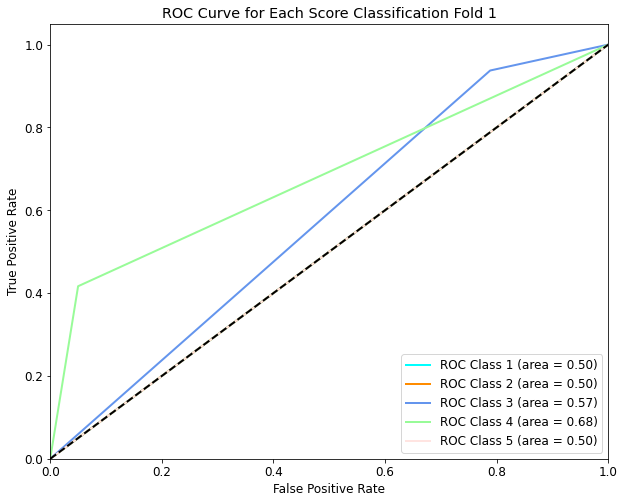

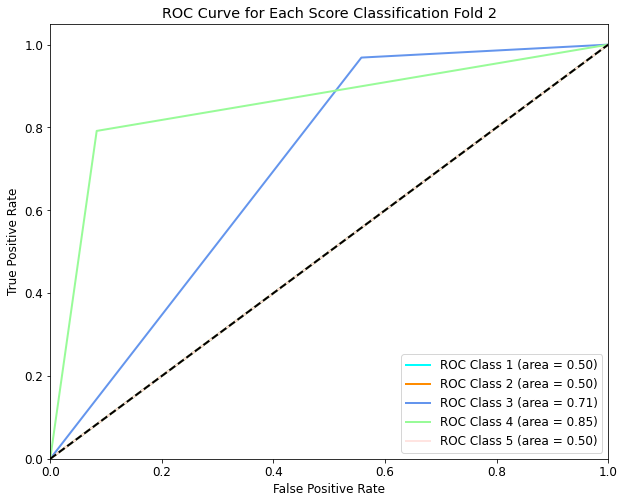

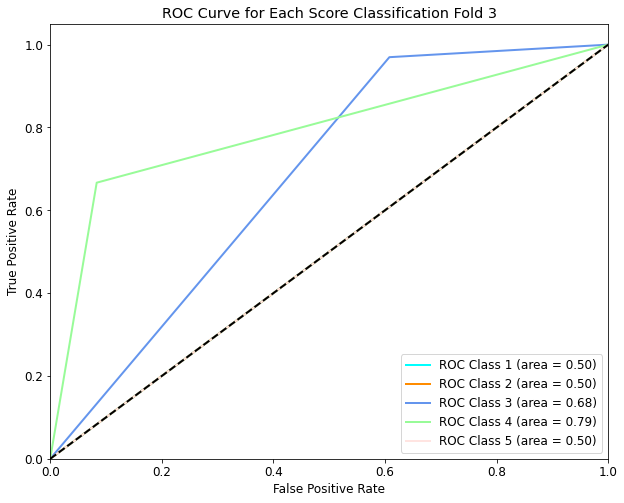

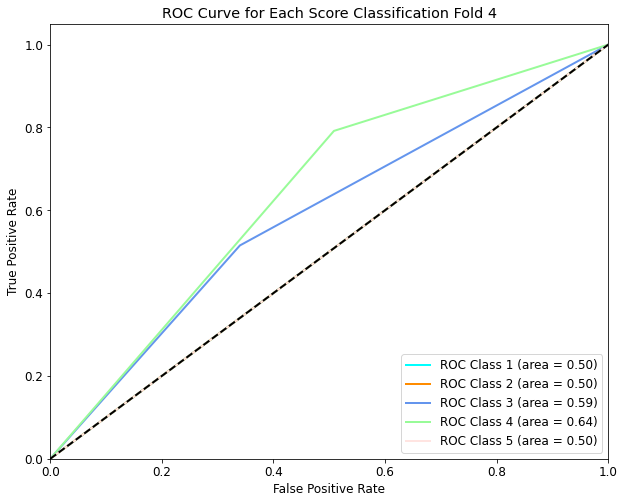

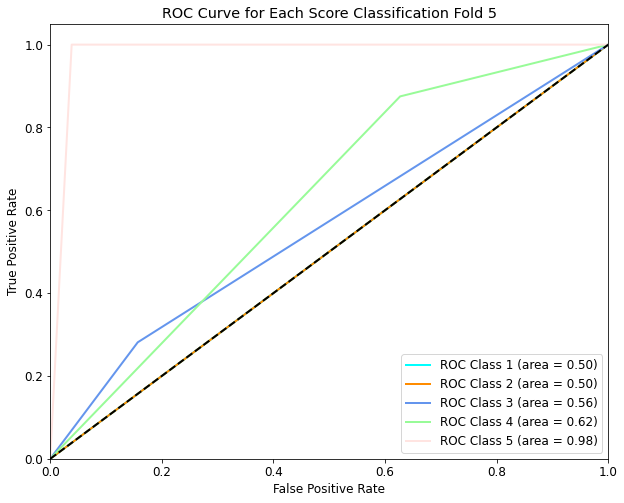

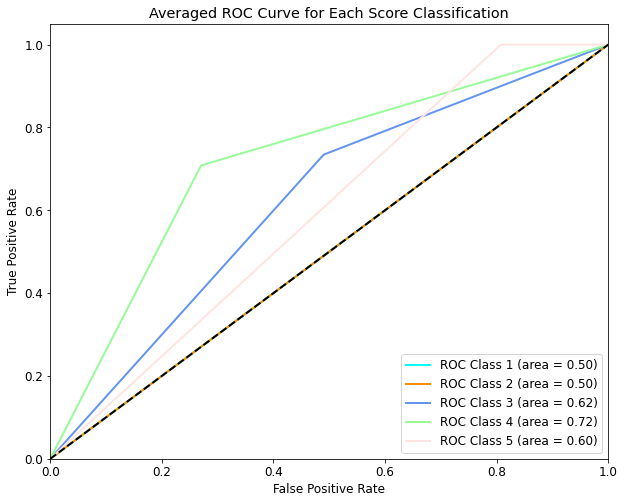

In [5]:
mvdd= mvGen.generateTreeCrossValidation(xData=xData, yData=yData, classes=["1", "2", "3", "4", "5"], 
                                        learningCriteria='gini', maxLevels=None, minSamplesPerLeaf=1, 
                                        modelName='Hemo_AllOutcomes', numFolds=5, 
                                        showIndividualROC=True)

In [6]:
# Get Feature importance
featureDict = dict(zip(hemo.columns, mvdd.model.feature_importances_))
featureImp = pd.DataFrame.from_dict(featureDict, orient='index')
featureImp.rename(columns = {0:'Feature Importance'}, inplace = True)
featureImp = featureImp.sort_values(by=['Feature Importance'], ascending=False)
featureImp.head(10)

,Feature Importance
Gender,0.337413
MPAP,0.229356
HRTRT,0.123925
BPDIAS,0.101743
BPSYS,0.061787
MAP,0.053186
CO,0.022775
PCWP,0.018580
PAS,0.015126
PAPP,0.007903


## Death Label


Total edges: 48 Nonterminal Edge 23
Must have more than 7 and less than 14 OR Edges
Best edge set: ['dashed', 'dashed', 'dashed', 'dashed', 'dashed', 'dashed', 'dashed', 'solid', 'dashed', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid']
Accuracy DT: 0.9404761904761905
Accuracy MVDD: 0.47619047619047616

Total edges: 38 Nonterminal Edge 18
Must have more than 5 and less than 11 OR Edges
Best edge set: ['dashed', 'dashed', 'dashed', 'dashed', 'dashed', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'dashed', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid']
Accuracy DT: 0.9047619047619048
Accuracy MVDD: 0.5952380952380952

Total edges: 46 Nonterminal Edge 22
Must have more than 7 and less than 13 OR Edges
Best edge set: ['dashed', 'dashed', 'dashed', 'dashed', 'dashed', 'dashed', 'dashed', 'solid', 'solid', 'dashed', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 's

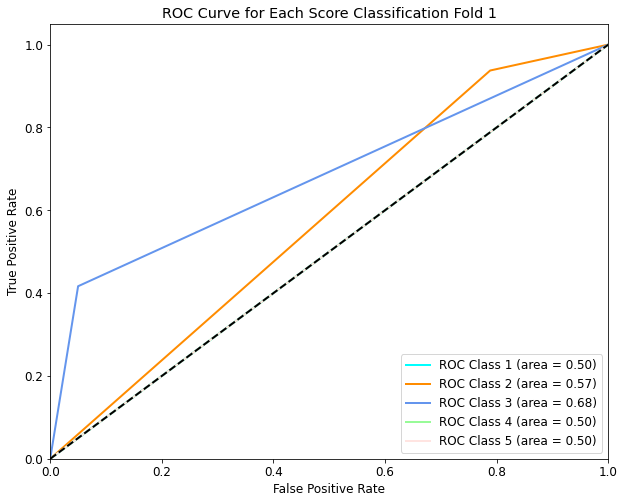

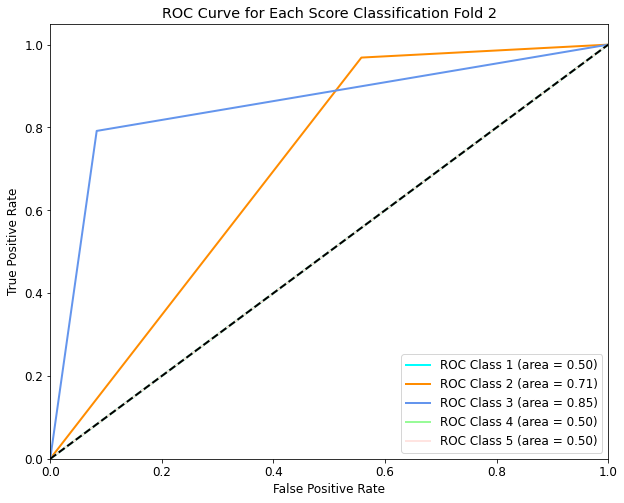

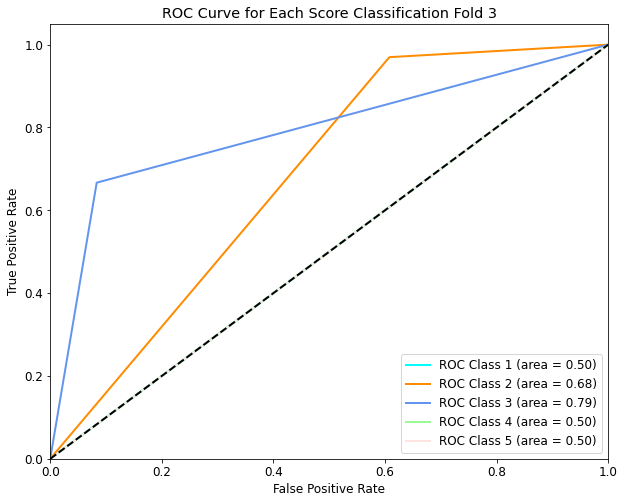

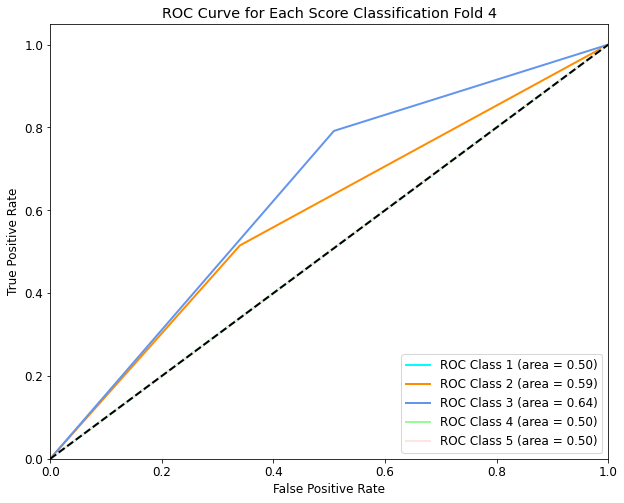

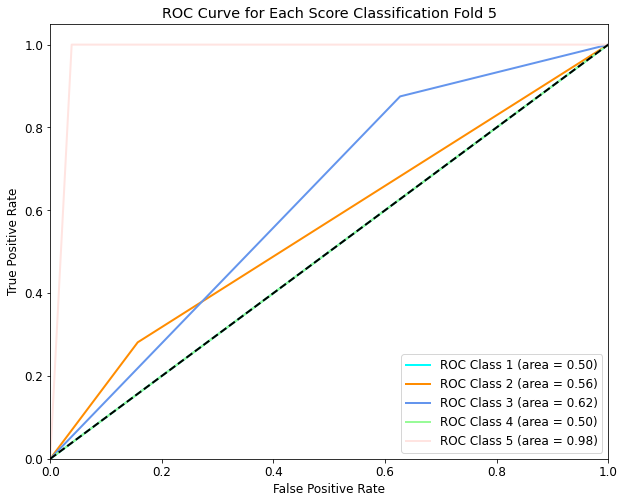

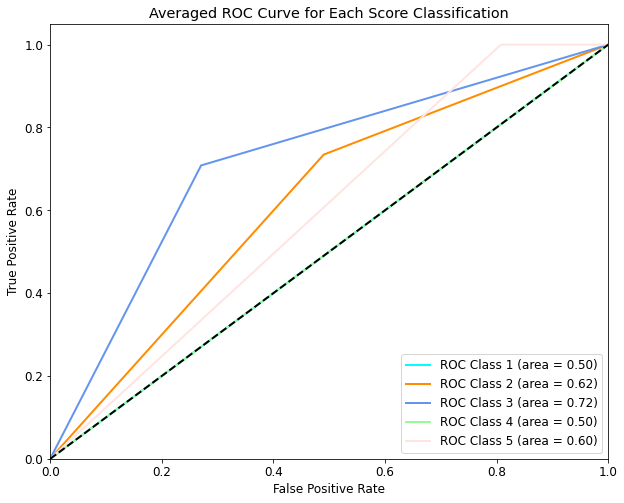

In [7]:
yData = death

mvdd= mvGen.generateTreeCrossValidation(xData=xData, yData=yData, classes=["1", "2", "3", "4", "5"], 
                                        learningCriteria='gini', maxLevels=None, minSamplesPerLeaf=1, 
                                        modelName='Hemo_Death', numFolds=5, 
                                        showIndividualROC=True)

In [8]:
# Get Feature importance
featureDict = dict(zip(hemo.columns, mvdd.model.feature_importances_))
featureImp = pd.DataFrame.from_dict(featureDict, orient='index')
featureImp.rename(columns = {0:'Feature Importance'}, inplace = True)
featureImp = featureImp.sort_values(by=['Feature Importance'], ascending=False)
featureImp.head(10)

,Feature Importance
Gender,0.337413
MPAP,0.229356
HRTRT,0.123925
BPDIAS,0.101743
BPSYS,0.061787
MAP,0.053186
CO,0.022775
PCWP,0.018580
PAS,0.015126
PAPP,0.007903


## Rehospitalization Label


Total edges: 48 Nonterminal Edge 23
Must have more than 7 and less than 14 OR Edges
Best edge set: ['dashed', 'dashed', 'dashed', 'dashed', 'dashed', 'dashed', 'dashed', 'solid', 'dashed', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid']
Accuracy DT: 0.9404761904761905
Accuracy MVDD: 0.47619047619047616

Total edges: 38 Nonterminal Edge 18
Must have more than 5 and less than 11 OR Edges
Best edge set: ['dashed', 'dashed', 'dashed', 'dashed', 'dashed', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'dashed', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid']
Accuracy DT: 0.9047619047619048
Accuracy MVDD: 0.5952380952380952

Total edges: 46 Nonterminal Edge 22
Must have more than 7 and less than 13 OR Edges
Best edge set: ['dashed', 'dashed', 'dashed', 'dashed', 'dashed', 'dashed', 'dashed', 'solid', 'solid', 'dashed', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 's

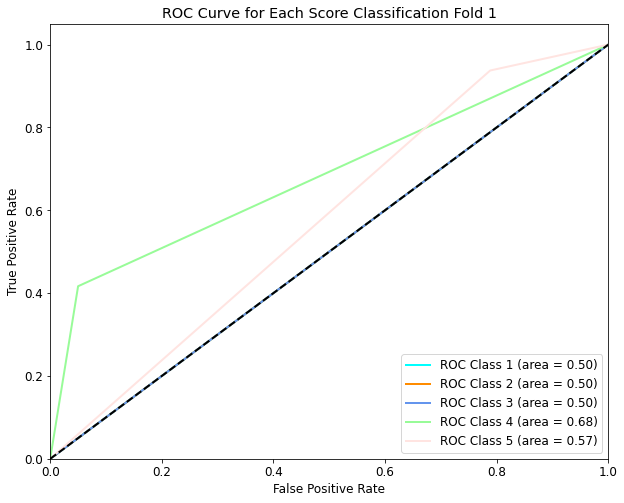

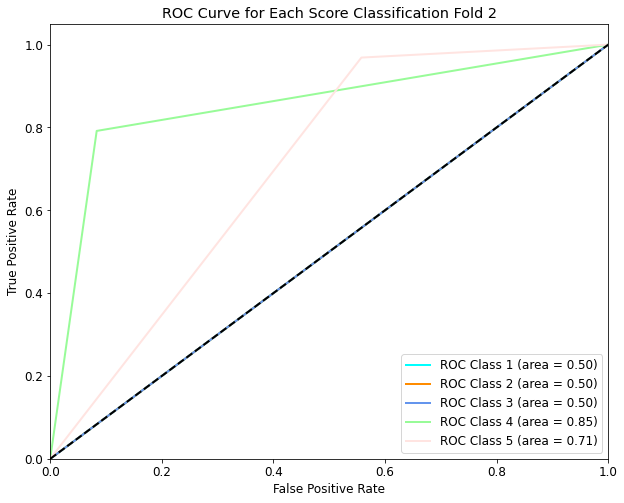

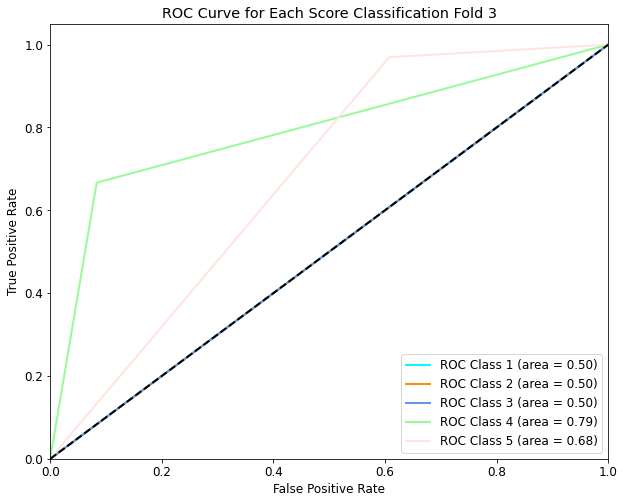

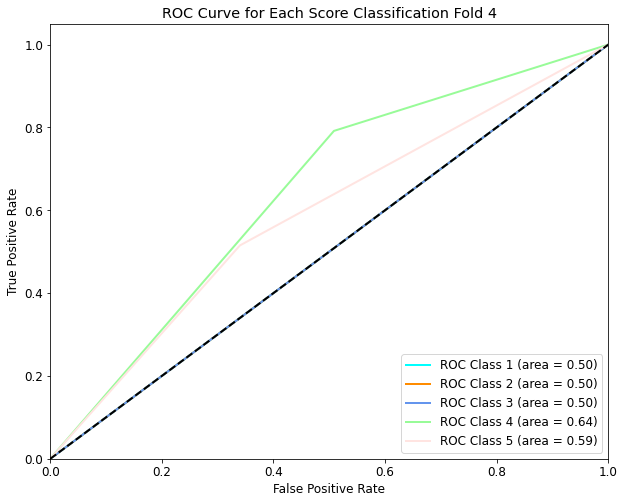

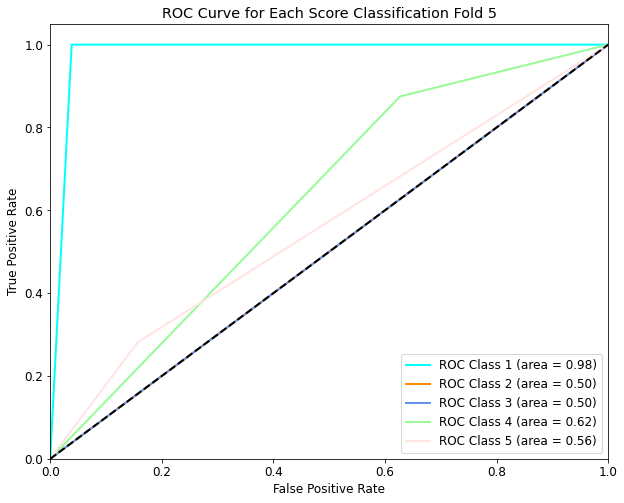

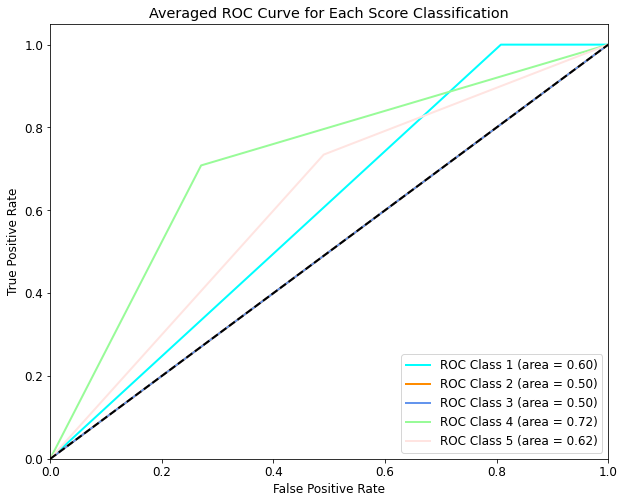

In [9]:
yData = rehosp

mvdd= mvGen.generateTreeCrossValidation(xData=xData, yData=yData, classes=["1", "2", "3", "4", "5"], 
                                        learningCriteria='gini', maxLevels=None, minSamplesPerLeaf=1, 
                                        modelName='Hemo_Rehosp', numFolds=5, 
                                        showIndividualROC=True)

In [10]:
# Get Feature importance
featureDict = dict(zip(hemo.columns, mvdd.model.feature_importances_))
featureImp = pd.DataFrame.from_dict(featureDict, orient='index')
featureImp.rename(columns = {0:'Feature Importance'}, inplace = True)
featureImp = featureImp.sort_values(by=['Feature Importance'], ascending=False)
featureImp.head(10)

,Feature Importance
Gender,0.337413
MPAP,0.229356
HRTRT,0.123925
BPDIAS,0.101743
BPSYS,0.061787
MAP,0.053186
CO,0.022775
PCWP,0.018580
PAS,0.015126
PAPP,0.007903


## Readmission Label


Total edges: 48 Nonterminal Edge 23
Must have more than 7 and less than 14 OR Edges
Best edge set: ['dashed', 'dashed', 'dashed', 'dashed', 'dashed', 'dashed', 'dashed', 'solid', 'dashed', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid']
Accuracy DT: 0.9404761904761905
Accuracy MVDD: 0.47619047619047616

Total edges: 38 Nonterminal Edge 18
Must have more than 5 and less than 11 OR Edges
Best edge set: ['dashed', 'dashed', 'dashed', 'dashed', 'dashed', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'dashed', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid']
Accuracy DT: 0.9047619047619048
Accuracy MVDD: 0.5952380952380952

Total edges: 46 Nonterminal Edge 22
Must have more than 7 and less than 13 OR Edges
Best edge set: ['dashed', 'dashed', 'dashed', 'dashed', 'dashed', 'dashed', 'dashed', 'solid', 'solid', 'dashed', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 's

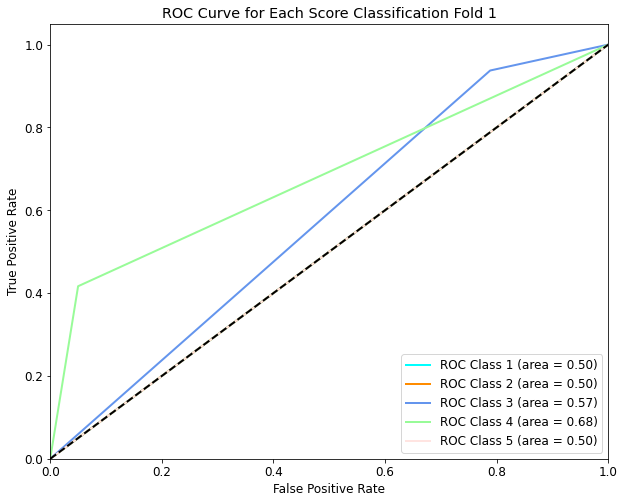

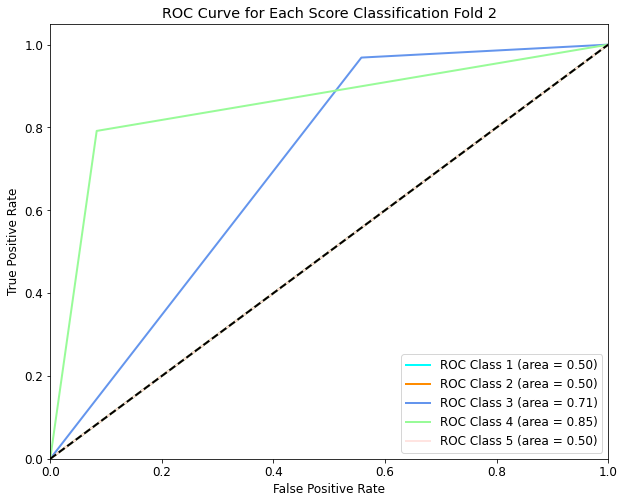

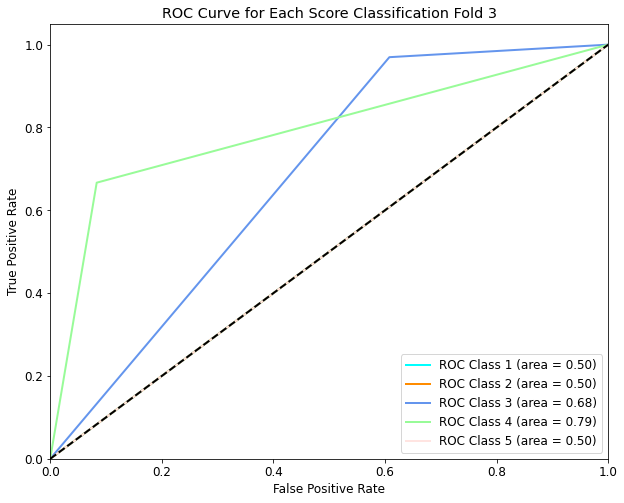

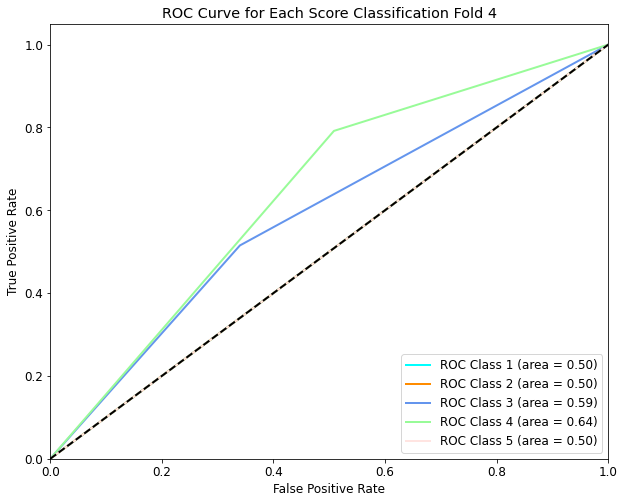

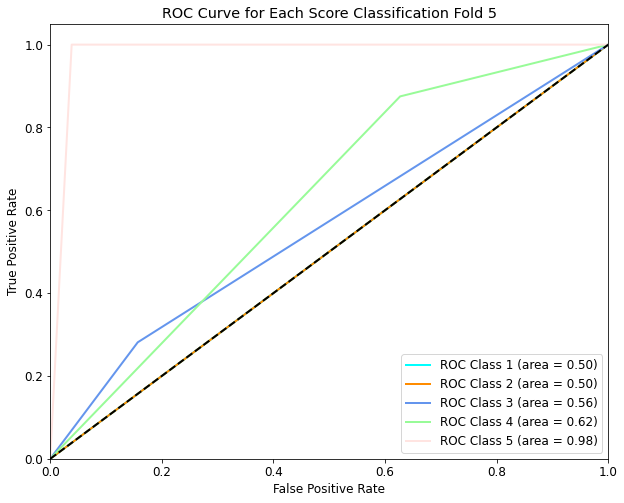

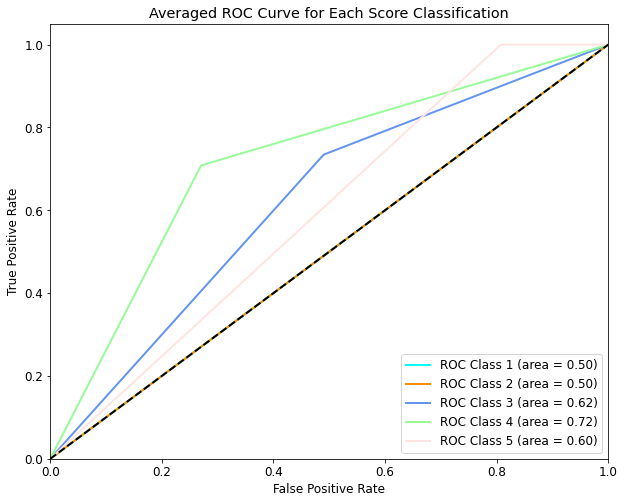

In [11]:
yData = readm

mvdd= mvGen.generateTreeCrossValidation(xData=xData, yData=yData, classes=["1", "2", "3", "4", "5"], 
                                        learningCriteria='gini', maxLevels=None, minSamplesPerLeaf=1, 
                                        modelName='Hemo_Readmission', numFolds=5, 
                                        showIndividualROC=True)

In [12]:
# Get Feature importance
featureDict = dict(zip(hemo.columns, mvdd.model.feature_importances_))
featureImp = pd.DataFrame.from_dict(featureDict, orient='index')
featureImp.rename(columns = {0:'Feature Importance'}, inplace = True)
featureImp = featureImp.sort_values(by=['Feature Importance'], ascending=False)
featureImp.head(10)

,Feature Importance
Gender,0.337413
MPAP,0.229356
HRTRT,0.123925
BPDIAS,0.101743
BPSYS,0.061787
MAP,0.053186
CO,0.022775
PCWP,0.018580
PAS,0.015126
PAPP,0.007903


# All Data

In [13]:
#Load original dataframes
allDataOrig = pd.read_csv('Data/Preprocessed Data/Cluster_AllData.csv', index_col='DEIDNUM')
allScores = allDataOrig['Score']
death = allDataOrig['ScoreDeath']
rehosp = allDataOrig['ScoreRehosp']
readm = allDataOrig['ScoreReadmission']

allDataOrig

,Age,Gender,Race,Wt,BMI,InitialHospDays,TotalHospDays,NYHA,MLHFS,AF,...,HR,PV,MAP,PP,PPP,PPRatio,Score,ScoreDeath,ScoreRehosp,ScoreReadmission
DEIDNUM,,,,,,,,,,,,,,,,,,,,,
72,88.0,2.0,1.0,57.100000,26.424175,9.0,16.0,4.0,76.0,1.0,...,104.0,12.452563,139.333333,26.0,0.276596,0.250000,4,5,5,5
72,88.0,2.0,1.0,52.000000,24.064047,9.0,16.0,3.0,76.0,1.0,...,92.0,12.452563,126.000000,26.0,0.302326,0.282609,4,5,5,5
81,69.0,1.0,1.0,102.363636,32.307675,5.0,13.0,4.0,21.0,1.0,...,70.0,-3.346568,125.333333,32.0,0.363636,0.457143,1,4,4,4
81,69.0,1.0,1.0,100.454545,31.705134,5.0,13.0,2.0,21.0,1.0,...,72.0,-3.346568,105.666667,34.0,0.441558,0.472222,1,4,4,4
86,56.0,2.0,2.0,98.636364,40.016375,3.0,3.0,4.0,NaN,0.0,...,86.0,5.478621,146.666667,30.0,0.300000,0.348837,3,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99302,41.0,1.0,2.0,97.400000,40.541103,21.0,21.0,NaN,79.0,0.0,...,75.0,25.535155,130.000000,55.0,0.550000,0.733333,1,4,4,4
99912,46.0,1.0,1.0,78.636364,25.677180,2.0,2.0,4.0,89.0,0.0,...,67.0,-13.911732,174.666667,38.0,0.316667,0.567164,3,1,1,2
99912,46.0,1.0,1.0,78.200000,25.534694,2.0,2.0,3.0,89.0,0.0,...,60.0,-13.911732,140.666667,24.0,0.255319,0.400000,3,1,1,2


In [14]:
# Preprocess and create training and testing sets
allData = allDataOrig.drop('Score', axis=1)
allData = allData.drop('ScoreDeath', axis=1)
allData = allData.drop('ScoreRehosp', axis=1)
allData = allData.drop('ScoreReadmission', axis=1)
allData = allData.replace(np.inf, 0)
allData = allData.fillna(0)

xData = allData
yData = allScores

## All Scores Label

In [15]:
#Perform Grid search to find best parameter set
# trialParams = {'criterion': ('gini', 'entropy'), 'max_depth': [3, 5, 7, 10, 13, 15, 20, 25, 30, None], 
#                'min_samples_leaf':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30]}

# mvGen.findBestModelParams(xData, yData, trialParams)


Total edges: 92 Nonterminal Edge 45
Must have more than 14 and less than 27 OR Edges
Best edge set: ['dashed', 'dashed', 'dashed', 'dashed', 'dashed', 'dashed', 'dashed', 'dashed', 'dashed', 'dashed', 'dashed', 'dashed', 'dashed', 'dashed', 'dashed', 'dashed', 'dashed', 'dashed', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid']
Accuracy DT: 0.8045977011494253
Accuracy MVDD: 0.29310344827586204

Total edges: 94 Nonterminal Edge 46
Must have more than 14 and less than 28 OR Edges
Best edge set: ['dashed', 'dashed', 'dashed', 'dashed', 'dashed', 'dashed', 'dashed', 'dashed', 'dashed', 'dashed', 'dashed', 'dashed', 'dashed', 'dashed', 'solid', 'solid', 'solid', 'solid', 'dashed', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'so

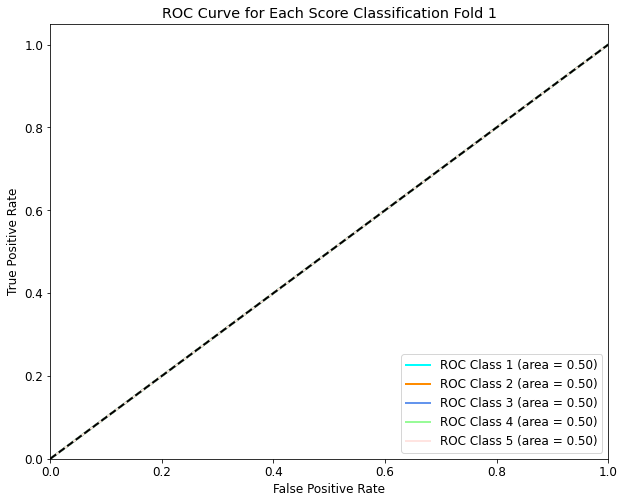

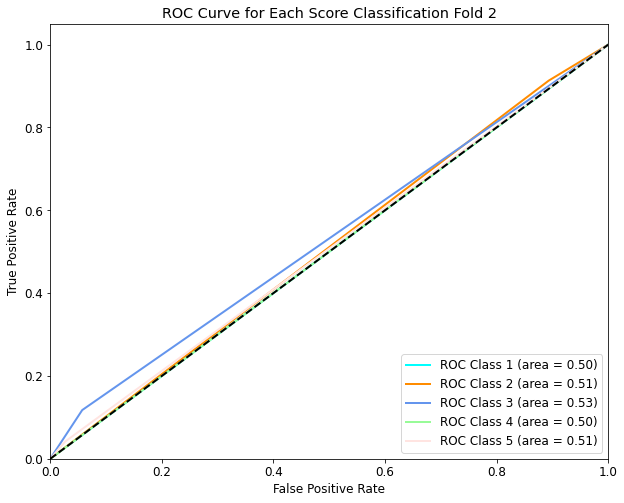

In [ ]:
mvdd= mvGen.generateTreeCrossValidation(xData=xData, yData=yData, classes=["1", "2", "3", "4", "5"], 
                                        learningCriteria='gini', maxLevels=None, minSamplesPerLeaf=1, 
                                        modelName='AllData_WConditions_AllOutcomes', numFolds=5, 
                                        showIndividualROC=True)

In [ ]:
# Get Feature importance
featureDict = dict(zip(allData.columns, mvdd.model.feature_importances_))
featureImp = pd.DataFrame.from_dict(featureDict, orient='index')
featureImp.rename(columns = {0:'Feature Importance'}, inplace = True)
featureImp = featureImp.sort_values(by=['Feature Importance'], ascending=False)
featureImp.head(10)

## Death Label

In [ ]:
yData = death

mvdd= mvGen.generateTreeCrossValidation(xData=xData, yData=yData, classes=["1", "2", "3", "4", "5"], 
                                        learningCriteria='gini', maxLevels=None, minSamplesPerLeaf=1, 
                                        modelName='AllData_WConditions_Death', numFolds=5, 
                                        showIndividualROC=True)

In [ ]:
# Get Feature importance
featureDict = dict(zip(allData.columns, mvdd.model.feature_importances_))
featureImp = pd.DataFrame.from_dict(featureDict, orient='index')
featureImp.rename(columns = {0:'Feature Importance'}, inplace = True)
featureImp = featureImp.sort_values(by=['Feature Importance'], ascending=False)
featureImp.head(10)

## Rehospitalization Label

In [ ]:
yData = rehosp

mvdd= mvGen.generateTreeCrossValidation(xData=xData, yData=yData, classes=["1", "2", "3", "4", "5"], 
                                        learningCriteria='gini', maxLevels=None, minSamplesPerLeaf=1, 
                                        modelName='AllData_WConditions_Rehosp', numFolds=5, 
                                        showIndividualROC=True)

In [ ]:
# Get Feature importance
featureDict = dict(zip(allData.columns, mvdd.model.feature_importances_))
featureImp = pd.DataFrame.from_dict(featureDict, orient='index')
featureImp.rename(columns = {0:'Feature Importance'}, inplace = True)
featureImp = featureImp.sort_values(by=['Feature Importance'], ascending=False)
featureImp.head(10)

## Readmission Label

In [ ]:
yData = readm

mvdd= mvGen.generateTreeCrossValidation(xData=xData, yData=yData, classes=["1", "2", "3", "4", "5"], 
                                        learningCriteria='gini', maxLevels=None, minSamplesPerLeaf=1, 
                                        modelName='AllData_WConditions_Readmission', numFolds=5, 
                                        showIndividualROC=True)

In [ ]:
# Get Feature importance
featureDict = dict(zip(allData.columns, mvdd.model.feature_importances_))
featureImp = pd.DataFrame.from_dict(featureDict, orient='index')
featureImp.rename(columns = {0:'Feature Importance'}, inplace = True)
featureImp = featureImp.sort_values(by=['Feature Importance'], ascending=False)
featureImp.head(10)

In [ ]:
allData.columns

# All Data without condition features

In [ ]:
# Remove condition columns
remCols= ['AF', 'AlchE', 'ANGP', 'ARRH',
       'CARREST', 'CVD', 'COPD', 'DEPR', 'DIAB', 'GOUT', 'HEPT', 'HTN',
       'MALIG', 'RENAL', 'SMOKING', 'STERD', 'StrokeTIA', 'VAHD', 'VF', 'VHD',
       'VT', 'ISCH', 'NonISCH', 'CABG', 'HTRANS', 'ICD', 'PACE', 'PTCI']

for r in remCols: 
    allData = allData.drop(r, axis=1)


xData = allData
yData = allScores

xData

## All Scores Label

In [ ]:
# #Perform Grid search to find best parameter set
# trialParams = {'criterion': ('gini', 'entropy'), 'max_depth': [3, 5, 7, 10, 13, 15, 20, 25, 30, None], 
#                'min_samples_leaf':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30]}

# mvGen.findBestModelParams(xData, yData, trialParams)

In [ ]:
mvdd= mvGen.generateTreeCrossValidation(xData=xData, yData=yData, classes=["1", "2", "3", "4", "5"], 
                                        learningCriteria='entropy', maxLevels=None, minSamplesPerLeaf=10, 
                                        modelName='AllData_AllOutcomes', numFolds=5, 
                                        showIndividualROC=True)

In [ ]:
# Get Feature importance
featureDict = dict(zip(hemo.columns, mvdd.model.feature_importances_))
featureImp = pd.DataFrame.from_dict(featureDict, orient='index')
featureImp.rename(columns = {0:'Feature Importance'}, inplace = True)
featureImp = featureImp.sort_values(by=['Feature Importance'], ascending=False)
featureImp.head(10)

## Death Label

In [ ]:
yData = death

mvdd= mvGen.generateTreeCrossValidation(xData=xData, yData=yData, classes=["1", "2", "3", "4", "5"], 
                                        learningCriteria='entropy', maxLevels=None, minSamplesPerLeaf=10, 
                                        modelName='AllData_Death', numFolds=5, 
                                        showIndividualROC=True)

In [ ]:
# Get Feature importance
featureDict = dict(zip(hemo.columns, mvdd.model.feature_importances_))
featureImp = pd.DataFrame.from_dict(featureDict, orient='index')
featureImp.rename(columns = {0:'Feature Importance'}, inplace = True)
featureImp = featureImp.sort_values(by=['Feature Importance'], ascending=False)
featureImp.head(10)

## Rehospitalization Label

In [ ]:
yData = rehosp

mvdd= mvGen.generateTreeCrossValidation(xData=xData, yData=yData, classes=["1", "2", "3", "4", "5"], 
                                        learningCriteria='entropy', maxLevels=None, minSamplesPerLeaf=10, 
                                        modelName='AllData_Rehosp', numFolds=5, 
                                        showIndividualROC=True)

In [ ]:
# Get Feature importance
featureDict = dict(zip(hemo.columns, mvdd.model.feature_importances_))
featureImp = pd.DataFrame.from_dict(featureDict, orient='index')
featureImp.rename(columns = {0:'Feature Importance'}, inplace = True)
featureImp = featureImp.sort_values(by=['Feature Importance'], ascending=False)
featureImp.head(10)

## Readmission Label

In [ ]:
yData = readm

mvdd= mvGen.generateTreeCrossValidation(xData=xData, yData=yData, classes=["1", "2", "3", "4", "5"], 
                                        learningCriteria='entropy', maxLevels=None, minSamplesPerLeaf=10, 
                                        modelName='AllData_Readmission', numFolds=5, 
                                        showIndividualROC=True)

In [ ]:
# Get Feature importance
featureDict = dict(zip(hemo.columns, mvdd.model.feature_importances_))
featureImp = pd.DataFrame.from_dict(featureDict, orient='index')
featureImp.rename(columns = {0:'Feature Importance'}, inplace = True)
featureImp = featureImp.sort_values(by=['Feature Importance'], ascending=False)
featureImp.head(10)